In [1]:
import geopandas as gpd
import pandas as pd
import zipfile
import shutil
from pathlib import Path
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = Path(r"C:\Users\matta\Desktop\Documents\Python\Geolocation\climate_data")
RAW_DIR = BASE_DIR / "climate_files"
WORK_DIR = BASE_DIR / "working_data"

ZIP_PATH = RAW_DIR / "ophz-0.3.zip"
EXTRACT_DIR = RAW_DIR / "ophz-0.3_extracted"

CLIMATE_PKL = WORK_DIR / "clean_labeled_climate_data_with_states.pkl"
OUTPUT_PKL = WORK_DIR / "clean_labeled_climate_data_with_phz.pkl"

# Loading data

In [3]:
df = pd.read_pickle(CLIMATE_PKL)
print(f"✅ Loaded climate DataFrame: {df.shape}")

# Ensure coordinates exist
assert {'latitude', 'longitude'}.issubset(df.columns), "Missing 'latitude' or 'longitude' columns!"

# Convert to GeoDataFrame
points_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["longitude"], df["latitude"]), crs="EPSG:4326")

✅ Loaded climate DataFrame: (470320, 127)


In [4]:
df.columns

Index(['longitude', 'latitude', 'jan_tmin', 'feb_tmin', 'mar_tmin', 'apr_tmin',
       'may_tmin', 'jun_tmin', 'jul_tmin', 'aug_tmin',
       ...
       'dec_vpdmin', 'annual_vpdmin', 'Level_1', 'Level_2', 'Level_3',
       'Level_4', 'ECO_NAME', 'climates_f', 'elevation', 'state'],
      dtype='object', length=127)

In [5]:
if not EXTRACT_DIR.exists():
    print(f"📦 Extracting {ZIP_PATH} to {EXTRACT_DIR}...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print("✅ Extraction complete.")
else:
    print("✅ Extracted directory already exists, skipping unzip.")

# Optional: delete ZIP file after extraction
if ZIP_PATH.exists():
    ZIP_PATH.unlink()
    print(f"🗑️ Deleted ZIP file: {ZIP_PATH}")

✅ Extracted directory already exists, skipping unzip.


In [6]:
# Find the shapefile (ends with .shp)
shapefiles = list(EXTRACT_DIR.glob("**/*.shp"))
if not shapefiles:
    raise FileNotFoundError(f"No .shp file found in {EXTRACT_DIR}")
shapefile_path = shapefiles[0]
print(f"🗺️ Found shapefile: {shapefile_path}")

phz_gdf = gpd.read_file(shapefile_path)
print(f"✅ Loaded {len(phz_gdf)} polygons from Plant Hardiness Zones shapefile.")
print("Columns:", list(phz_gdf.columns))

🗺️ Found shapefile: C:\Users\matta\Desktop\Documents\Python\Geolocation\climate_data\climate_files\ophz-0.3_extracted\ophz-0.3\shp\ophz.shp
✅ Loaded 29867 polygons from Plant Hardiness Zones shapefile.
Columns: ['temp', 'zone', 'geometry']


In [7]:
phz_gdf.head()

,temp,zone,geometry
0,10,8a,"POLYGON ((-123.17172 49.00639, -123.16581 49.0..."
1,10,8a,"POLYGON ((-123.14463 49.0031, -123.12102 49.00..."
2,15,8b,"POLYGON ((-123.09292 48.98739, -123.08701 48.9..."
3,10,8a,"POLYGON ((-123.09984 49.00332, -123.07622 49.0..."
4,10,8a,"POLYGON ((-122.79389 49.00725, -122.78798 49.0..."


In [8]:
phz_gdf.temp.value_counts()

temp
-10    3797
-15    3572
-5     3491
-20    3066
 0     2813
-25    2559
 5     1954
 10    1691
-30    1555
 15    1544
 20    1297
 25     979
-35     685
 30     567
 35     141
-40      85
 40      71
Name: count, dtype: int64

In [9]:
phz_gdf.zone.value_counts()

zone
6a     3797
5b     3572
6b     3491
5a     3066
7a     2813
4b     2559
7b     1954
8a     1691
4a     1555
8b     1544
9a     1297
9b      979
3b      685
10a     567
10b     141
3a       85
11a      71
Name: count, dtype: int64

In [10]:
phz_gdf = phz_gdf.to_crs(points_gdf.crs)

In [11]:
# Joining PHZs to climate data

In [12]:
# Perform spatial join
print("⚡ Performing spatial join...")
joined = gpd.sjoin(points_gdf, phz_gdf[['temp', 'zone', "geometry"]], how="left", predicate="within")

⚡ Performing spatial join...


In [13]:
df[['plant_hardiness_zone', 'usda_hardiness_temp']] = joined[['zone', 'temp']]

# Data validation

In [14]:
df.columns

Index(['longitude', 'latitude', 'jan_tmin', 'feb_tmin', 'mar_tmin', 'apr_tmin',
       'may_tmin', 'jun_tmin', 'jul_tmin', 'aug_tmin',
       ...
       'Level_1', 'Level_2', 'Level_3', 'Level_4', 'ECO_NAME', 'climates_f',
       'elevation', 'state', 'plant_hardiness_zone', 'usda_hardiness_temp'],
      dtype='object', length=129)

In [15]:
df.plant_hardiness_zone.value_counts(dropna=False)

plant_hardiness_zone
6a     58938
6b     52889
5b     45259
8a     42262
4b     41614
5a     39039
7a     38630
4a     36113
7b     32766
8b     30326
9a     19340
3b     14020
9b     13182
10a     3319
3a      1899
10b      672
NaN       41
11a       11
Name: count, dtype: int64

In [16]:
df.usda_hardiness_temp.value_counts(dropna=False)

usda_hardiness_temp
-10.0    58938
-5.0     52889
-15.0    45259
 10.0    42262
-25.0    41614
-20.0    39039
 0.0     38630
-30.0    36113
 5.0     32766
 15.0    30326
 20.0    19340
-35.0    14020
 25.0    13182
 30.0     3319
-40.0     1899
 35.0      672
 NaN        41
 40.0       11
Name: count, dtype: int64

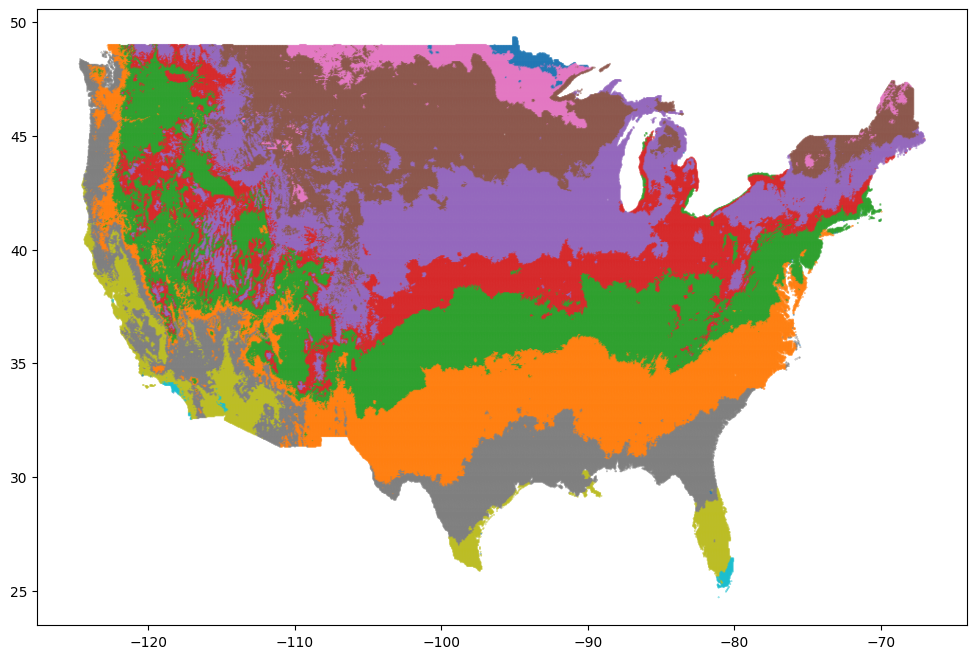

In [17]:
cat_codes, cat_labels = pd.factorize(df["plant_hardiness_zone"])

plt.figure(figsize=(12, 8))
plt.scatter(df["longitude"], df["latitude"], c=cat_codes, cmap="tab10", s=0.1, alpha=0.8)
plt.show()

# Saving

In [18]:
df.to_pickle(OUTPUT_PKL)
print(f"💾 Saved updated DataFrame to: {OUTPUT_PKL}")

💾 Saved updated DataFrame to: C:\Users\matta\Desktop\Documents\Python\Geolocation\climate_data\working_data\clean_labeled_climate_data_with_phz.pkl
